## Lab3 Part 2

Lab3 is splitted into two parts as it is gettign really long.
## Task 5.1 Dynamic Programming
The goal of this second half of the lab is to investigate dynamic progamming along scanlines in stereo vision.  In this part of the practical, we build a basic dynamic programming algorithm, which will solve the same problem as presented in the notes.  

In Task5 we will apply this to the stereo problem.  

Use the template below, filling in parts marked "TO DO" (only todo for Task 5.1 one is in functions.py).



In [6]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
from functions import dynamicProgram
plt.close('all')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# define unary costs : unaryCosts[d,j] represents the cost for having
# disparity d at pixel j.
unaryCosts = np.array([[2.0, 1.1, 5.7, 1.5, 6.0, 3.1],
              [0.8, 4.8, 1.0, 3.0, 6.9, 3.3],
              [4.3, 2.3, 2.4, 2.4, 6.6, 6.2],
              [6.4, 0.0, 6.1, 0.8, 7.1, 2.1],
              [2.3, 2.2, 4.9, 8.9, 1.0, 9.8]])

# define pairwise costs:  pairwiseCosts[a,b] represents the cost for changing from 
# disparity level A at pixel j to disparity level B at pixel j+1;
pairwiseCosts = np.array([[   0,   2, 100, 100, 100],
                          [   2,   0,   2, 100, 100],
                          [ 100,   2,   0,   2, 100],
                          [ 100, 100,   2,   0,   2],
                          [ 100, 100, 100,   2,   0]])



In [8]:
# TODO Fill in the dynamicProgram function in "functions.py"

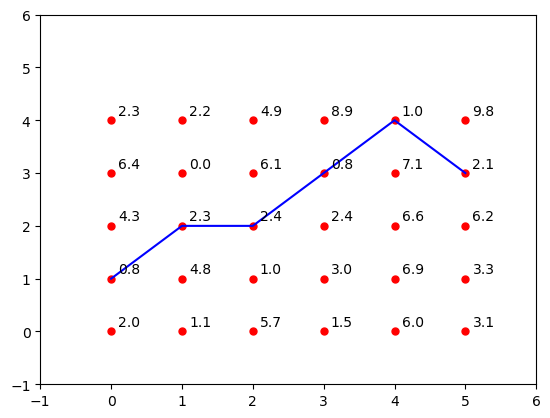

Path Cost = 17.4


In [9]:

# Now, use dynamic programming to find best solution.
bestPath = dynamicProgram(unaryCosts,pairwiseCosts)
# display the nodes
nY = len(unaryCosts)
nX = len(unaryCosts[0])
plt.axis([-1, 6, -1, 6])
for cY in range(nY):
    for cX in range(nX):
        plt.plot(cX,cY,'ro',ms=5.)
        plt.text(cX+.1, cY+.1, unaryCosts[cY,cX])


# display the best path
plt.plot(range(nX),bestPath,'b-')
plt.show()


# calculate the cost of the path computed
# Is there a bug in the following line?
bestPathCostUnary = np.sum((np.transpose(unaryCosts).reshape((nX*nY,1)))[(np.add(nY * np.array(range(nX)),np.transpose(bestPath)[0])).astype(int)])
bestPathCostPairwise = np.sum(np.transpose(pairwiseCosts).reshape((nY*nY,1))[np.array([bestPath[0:-1]+nY*bestPath[1:]]).reshape((1,nY)).astype(int)[0]])
bestCost = bestPathCostUnary+bestPathCostPairwise
print('Path Cost =',bestCost)

## Task 5.2 Dynamic Programming for stereo depth estimation


The goal of this part of the practical is to use the dynamic programming routine that you developed in the first part to solve the dense stero problem.

Use the template below, filling in parts marked "TO DO".

### Extra Tasks:
Task hint: Crop or downsample your image if your stereo is slow

Task1: Capture or find two image pairs: one with good stereo depth and one with bad stereo depth result. Note that should have you camera moved horizontally (in parallel to the circuit board plane) with a baseline, and there should be no moving objects in the scene.

Task2: Measure your baseline distance between the camera with a ruler, does the depth esimation match the real distance？

Task3: (Unmarked Optional) Can you use two cameras at the same time for stereo capture?

In [10]:
%load_ext autoreload
%autoreload 2

import numpy as np 
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
from functions import dynamicProgram, dynamicProgramVec
plt.close('all')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# load in images and ground truth
data = loadmat('../dataset/StereoData.mat')
im1 = data['im1'].astype('int')
im2 = data['im2'].astype('int')
gt = data['gt'].astype('int')

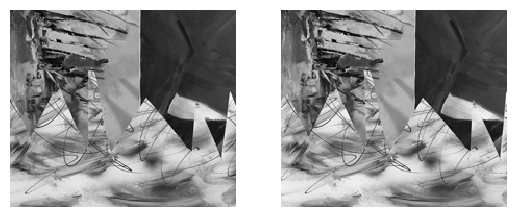

In [12]:
# ground truth disparity is originally expressed in 16'ths of pixels but we 
# will only consider whole-pixel shifts
gtDisp = np.round(gt.astype(float)/16)

im1show = im1
im2show = im2
if np.max(im1) > 1:
    im1show = im1.astype(float)/255.
    im2show = im2.astype(float)/255.
    
# display image
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(im1, cmap='gray', interpolation='nearest', aspect=1)
ax1.axis('off')
ax2.imshow(im2, cmap='gray', interpolation='nearest', aspect=1)
ax2.axis('off')
plt.show()

### Complete the TODOs in the final cell below

Here we are going to make use of the "dynamicProgram" function we just wrote.

We will first calculate the unary costs before using our function to calculate estimated disparity.

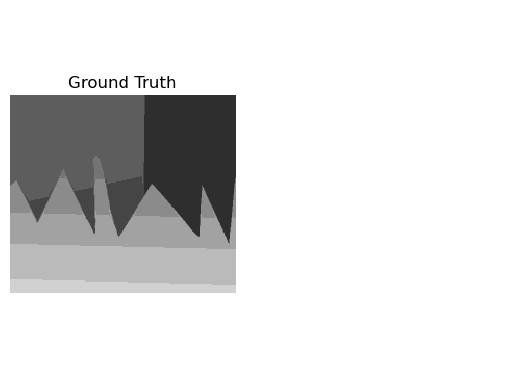

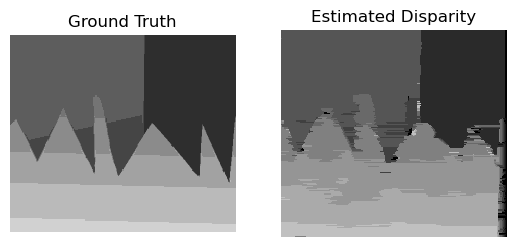

In [13]:
# figure out size of image
imY = len(im1)
imX = len(im1[0])

# define maximum disparity 
maxDisp = 10

# set up pairwiseCosts - we will define a fixed cost of alpha for changing
# disparity or zero cost for staying the same
alpha = 10
pairwiseCosts = alpha*np.ones([maxDisp,maxDisp])-alpha*np.eye(maxDisp)

# initialize the disparity map that we will estimate
estDisp = np.zeros([imY,imX-maxDisp])

# define standard deviation of noise
noiseSD = 6

# display ground truth and estimated disparity
plt.close('all')
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(gtDisp, vmin=0,vmax=11, cmap='gray', extent=[0,len(gtDisp[0]),0,len(gtDisp)],interpolation='nearest')
ax1.axis('off')
ax1.set_title('Ground Truth')
ax2.axis('off')
plt.show()

# run through each line of image
for cY in range(imY):
    # print('Procesing scanline ',cY) # Commented by Lucas
    
    # define unary costs - we will not use the last few columns of the
    # image as the disparity might map the pixel outside the valid area of
    # the second image
    unaryCosts = np.zeros([maxDisp,imX-maxDisp])
    
    for cDisp in range(maxDisp):
        cost=np.zeros(imX-maxDisp)
        for cX in range(imX-maxDisp):
            #TODO - calculate cost for this disparity. This is the 
            #negative log likelihood, where the likelihood is a Gaussian
            #with a mean of the value (i.e. intensity) at the offset pixel 
            #in image2 and a standard deviation of "noiseSD". 
            if cX+cDisp+maxDisp < imX:
                cost[cX] = np.sum((im1[cY,cX:cX+maxDisp]-im2[cY,cX+cDisp:cX+cDisp+maxDisp])**2)/(2*noiseSD**2)
            else:
                cost[cX] = np.inf
        
        # TODO store this cost in the unaryCosts matrix
        # unaryCosts[ , ] = ...
        unaryCosts[cDisp,:] = cost
            
    # TODO uncomment the line below and call the function that you wrote in the previous section (copy it
    # into the cell above)
    estDisp[cY,:] = np.transpose(dynamicProgram(unaryCosts,pairwiseCosts))

    # display solution so far - NO
    # display the final disparity map
    if cY == imY-1:
        f, (ax1, ax2) = plt.subplots(1, 2)
        ax1.clear()
        ax1.imshow(gtDisp, vmin=0,vmax=11, cmap='gray', extent=[0,len(gtDisp[0]),0,len(gtDisp)],interpolation='nearest')
        ax1.axis('off')
        ax1.set_title('Ground Truth')
        ax2.clear()
        ax2.imshow(estDisp, vmin=0,vmax=12, cmap='gray', extent=[0,len(estDisp[0]),0,len(estDisp)],interpolation='nearest')
        ax2.axis('off')
        ax2.set_title('Estimated Disparity')
        plt.show()

# TODO - investigate how different values of alpha and noiseSD affect the results

# TODO (optional) - rewrite the the "dynamicProgram" in the "dynamicProgramVec" function to make it more efficient. 
# Check the improvements by timining the function calls.

# TODO (optional) - you should be able to rewrite this (calculating unary costs) with fewer loops once you have
#the general idea so that it runs faster. Again you can check the speed improvements by timing them.

# TODO (optional)- adapt the algorithm so that it makes use of colour information

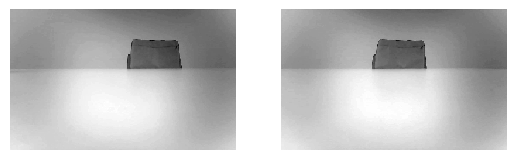

/var/folders/x3/5lsmd6zd25d0t17vwvn5r4j40000gn/T/ipykernel_67344/3951948347.py:83: RuntimeWarning: divide by zero encountered in divide
  depthMap = focalLength*baseline/estDisp # in cm


In [14]:
# Use our own dataset for depth estimation
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
from functions import dynamicProgram
import cv2
plt.close('all')

# load in images and ground truth, two jpg images
im1 = plt.imread('./lab3b_depth_estimation/left1.jpg')
im2 = plt.imread('./lab3b_depth_estimation/right1.jpg')

# convert to grayscale
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

# Downsample the images
# it will effect focal length
downSample = 0.5
im1 = cv2.resize(im1, (0,0), fx=downSample, fy=downSample)
im2 = cv2.resize(im2, (0,0), fx=downSample, fy=downSample)

# figure out size of image
imY = len(im1)
imX = len(im1[0])

# define maximum disparity 
# Increase the max disparity to dectect near objects
maxDisp = 100

# set up pairwiseCosts - we will define a fixed cost of alpha for changing
# disparity or zero cost for staying the same
# Make the alpha smaller to make the disparity map more smooth
alpha = 1e-6
pairwiseCosts = alpha*np.ones([maxDisp,maxDisp])-alpha*np.eye(maxDisp)

# initialize the disparity map that we will estimate
estDisp = np.zeros([imY,imX-maxDisp])

# define standard deviation of noise
noiseSD = 200

# display the two images in subplots
plt.close('all')
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(im1, cmap='gray', interpolation='nearest', aspect=1)
ax1.axis('off')
ax2.imshow(im2, cmap='gray', interpolation='nearest', aspect=1)
ax2.axis('off')

plt.show()

# run through each line of image
for cY in range(imY):
    # print('Procesing scanline ',cY) # Commented by Lucas
    
    # define unary costs - we will not use the last few columns of the
    # image as the disparity might map the pixel outside the valid area of
    # the second image
    unaryCosts = np.zeros([maxDisp,imX-maxDisp])
    
    for cDisp in range(maxDisp):
        cost=np.zeros(imX-maxDisp)
        for cX in range(imX-maxDisp):
            #TODO - calculate cost for this disparity. This is the 
            #negative log likelihood, where the likelihood is a Gaussian
            #with a mean of the value (i.e. intensity) at the offset pixel 
            #in image2 and a standard deviation of "noiseSD". 
            if cX+cDisp+maxDisp < imX:
                cost[cX] = np.sum((im1[cY,cX:cX+maxDisp]-im2[cY,cX+cDisp:cX+cDisp+maxDisp])**2)/(2*noiseSD**2)
            else:
                cost[cX] = np.inf
        
        # TODO store this cost in the unaryCosts matrix
        # unaryCosts[ , ] = ...
        unaryCosts[cDisp,:] = cost
    
    estDisp[cY,:] = np.transpose(dynamicProgram(unaryCosts,pairwiseCosts))

# Calculate the depth map
focalLength = 916 * downSample # in pixels
baseline = 20 # in cm
depthMap = focalLength*baseline/estDisp # in cm


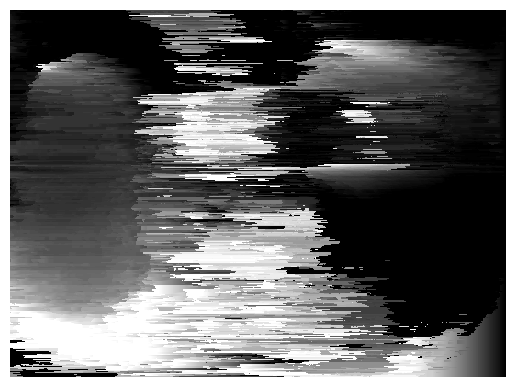

In [15]:
%matplotlib inline
# display the estimated disparity map
plt.imshow(estDisp, cmap='gray', extent=[0,len(estDisp[0]),0,len(estDisp)],interpolation='nearest')
plt.axis('off')
plt.show()

Selected pixel for depth examination: (x, y) = (403, 96)
Estimated Depth: 2.54 m


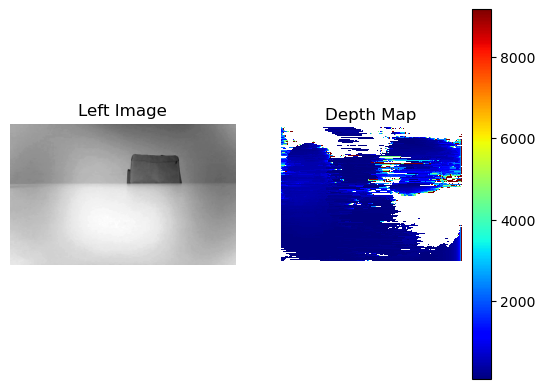

In [17]:
%matplotlib inline
print("Selected pixel for depth examination: (x, y) = (403, 96)")
print(f"Estimated Depth: {depthMap[96, 403]/100:.2f} m")
# display the left image and the depth map
plt.figure()
plt.subplot(1,2,1)
plt.imshow(im1, cmap='gray')
plt.axis('off')
plt.title('Left Image')
plt.subplot(1,2,2)
plt.imshow(depthMap, cmap='jet', interpolation='nearest', aspect=1)
plt.axis('off')
plt.title('Depth Map')
plt.colorbar()
plt.show()